## Maximum Billboard Covering Location Problem (MBCLP) solved by Genetic Algorithm (GA)

In [1]:
# from Algorithm.GA import display_points_with_mclp, GeneticAlgorithm
from Algorithm.GA import GeneticAlgorithm
import random
import numpy as np

## Load the real-world datasets

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [3]:
%%time
ls = gpd.read_file("./xqd.shp")
#ls['POINT_X'] = ls.geometry.x
#ls['POINT_Y'] = ls.geometry.y
ls.head(3)

CPU times: total: 141 ms
Wall time: 324 ms


,Id,ORIG_FID,POINT_X,POINT_Y,ID_1,公交站,充电桩,公交线,路网密,建筑密,微博密,五环人,权重,X1,Y1,geometry
0,0,5560,962307.237993,4.426070e+06,3345,0.558738,0.319934,0.613977,0.689915,0.222982,0.135555,0.162794,0.387634,0.697211,0.00000,POINT (962307.238 4426069.745)
1,0,5561,962521.258464,4.426083e+06,3346,0.553029,0.292546,0.596920,0.726470,0.190748,0.101671,0.189604,0.382674,0.717131,0.00000,POINT (962521.258 4426082.721)
2,0,5692,961220.343221,4.426283e+06,3472,0.645604,0.472511,0.730367,0.775091,0.165895,0.126567,0.084088,0.425274,0.597610,0.01992,POINT (961220.343 4426282.649)


In [4]:
def normalize_to_1_10(data):
    """
    将一组数据归一化到1-10
    """
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) * 9 + 1 for x in data]
    return normalized_data
# times -1 for maximizing the sum
#ls['speed_pct_freeflow_rev'] = ls.pct_from_f * (-1)
#speed_pct_freeflow_rev-权重、speed_pct_freeflow_rev_norm-权重_norm
ls['权重_norm'] = normalize_to_1_10(ls['权重'])

total_pop = sum(ls['权重'])
total_pop_norm = sum(ls['权重_norm'])
print("The number of records is ", len(ls))
print("The total speed unit are ", total_pop)
print("The total norm speed unit are ", total_pop_norm)

The number of records is  1559
The total speed unit are  575.4569846311647
The total norm speed unit are  6480.015742024948


In [5]:
%%time
sitedf = gpd.read_file("./hxd.shp")
#sitedf['POINT_X1'] = sitedf.LONGITUDE
#sitedf['POINT_Y1'] = sitedf.LATITUDE
print("The number of screen is ", len(sitedf))

#sitedf = pd.read_csv("./data/real/billboards_nyc.csv")
# sites = np.array(sitedf[['NORM_X', 'NORM_Y']], dtype=np.float64)
#print("The number of billboards in Seattle area is ", len(sitedf))
#sitedf.head(3)

The number of screen is  572
CPU times: total: 719 ms
Wall time: 939 ms


## Normalization

In [6]:
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [7]:
ls_X = np.array(ls['POINT_X'])
ls_Y = np.array(ls['POINT_Y'])
bbs_X = np.array(sitedf['POINT_X'])
bbs_Y = np.array(sitedf['POINT_Y'])
X = np.concatenate([ls_X, bbs_X])
Y = np.concatenate([ls_Y, bbs_Y])
NORM_X, NORM_Y, S = Normalization(X, Y)
ls['NORM_X'] = NORM_X[:len(ls)]
ls['NORM_Y'] = NORM_Y[:len(ls)]
sitedf['NORM_X'] = NORM_X[len(ls):]
sitedf['NORM_Y'] = NORM_Y[len(ls):]

In [8]:
def generate_candidate_sites(sites, M=None, heuristic = None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic:
    Return:
        sites: a Numpy array with shape of (M,2)
    '''

    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        np.random.seed(0)
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [9]:
bbs_ = generate_candidate_sites(sitedf, M=None, heuristic="")

In [10]:
users = np.array(ls[['NORM_X', 'NORM_Y']])
facilities = np.array(bbs_[['NORM_X', 'NORM_Y']])
demand = np.array(ls['权重'])
p = 25
real_radius = 2000
radius = 500/S

dist = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
A = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
mask1 = A <= radius
A[mask1] = 1
A[~mask1] = 0

In [11]:
S

12496.40047999937

In [12]:
radius

0.040011521781832746

In [13]:
genetic = GeneticAlgorithm(len(ls), len(bbs_), p, dist, radius, demand)
genetic.optimize()
obj = np.sum(demand) - genetic.top_chromosome.fitness
centers = genetic.top_chromosome.content

print("The Set of centers are: %s" % centers)
print("The objective is: %s" % str(round(obj)))

Current top solution: [99, 369, 360, 318, 36, 171, 359, 339, 213, 315, 208, 97, 534, 191, 482, 358, 338, 423, 448, 95, 302, 61, 9, 469, 260] f=457

Final top solution: [408, 443, 216, 66, 214, 13, 203, 275, 546, 249, 342, 76, 221, 72, 209, 228, 525, 62, 37, 219, 260, 98, 115, 46, 213] f=431
Time: 00:00:2.2950
The Set of centers are: [408, 443, 216, 66, 214, 13, 203, 275, 546, 249, 342, 76, 221, 72, 209, 228, 525, 62, 37, 219, 260, 98, 115, 46, 213]
The objective is: 144


In [14]:

# ls.plot(ax=ax, column=ls['权重'], k=5, markersize=5, cmap='Blues', label='Demand Points')

In [15]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [16]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20, 12))
    ls.plot(ax=ax, column=ls['权重'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Billboards')
#                 circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], 0.005, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=10,
                           label='Optimized Selected Billboards')
#                 circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], 500, color='C1', fill=False, lw=2)
            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both', left=False, top=False, right=False,
                   bottom=False, labelleft=False, labeltop=False,
                   labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve 500 m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax=ax, x=0.05, y=0.05)
    render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.01, ratio=0.7)
    ax.legend(loc='lower right', markerscale=2)
    return ax

<Axes: title={'center': 'Selected 25 Sites that Serve 500 m'}>

D:\Program Files\anaconda3\envs\higis\lib\site-packages\matplotlib\patches.py:1566: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
D:\Program Files\anaconda3\envs\higis\lib\site-packages\matplotlib\patches.py:1567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))


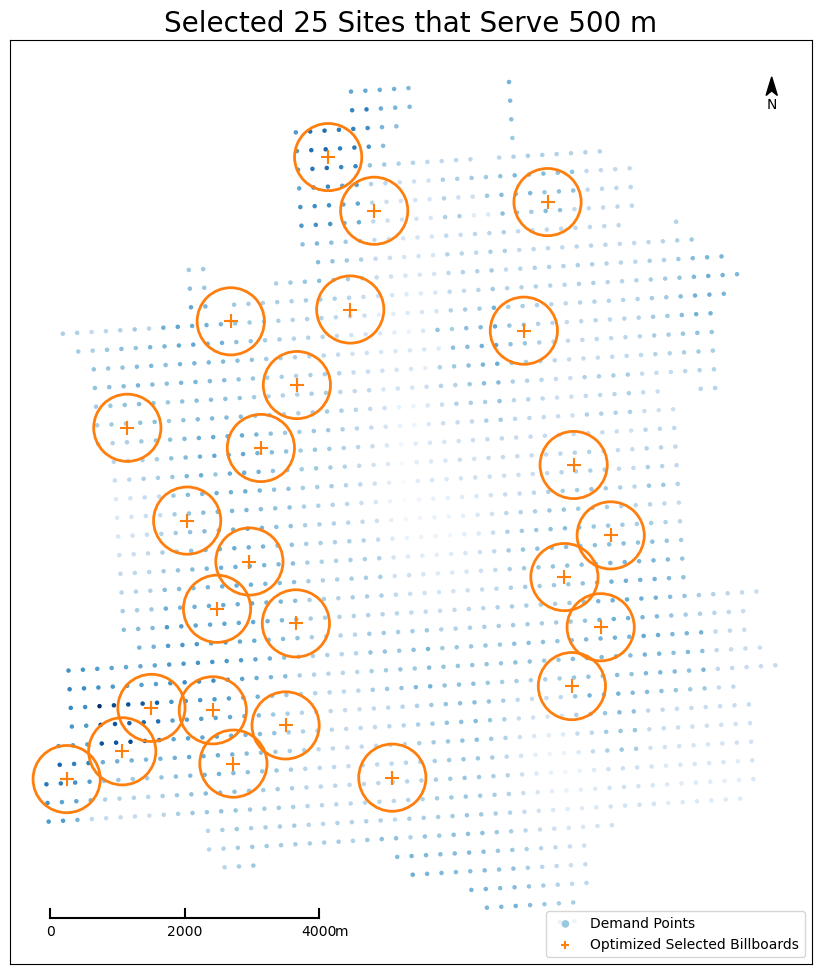

In [17]:
opt_sites = bbs_.iloc[centers]
plot_result(ls,opt_sites,500)

In [18]:
opt_sites = bbs_.iloc[centers]
opt_sites.head(3)

,Field1,SCREEN_ID,LONGITUDE,LATITUDE,ALLOW_PLAY,ALLOW_PL_1,ALLOW_PL_2,NOT_ALLOWE,NOT_ALLO_1,NOT_ALLO_2,...,STATUS,PACK_NAME,PROJECT_NA,X2,Y2,POINT_X,POINT_Y,geometry,NORM_X,NORM_Y
408,41166.0,01321ae1c00001ad,116.352371,39.940849,0.0,0.0,0.0,0.0,0.0,None,...,1.0,0.0,0.0,0.280677,0.648677,957409.096615,4.435006e+06,POINT (957409.097 4435005.795),0.219387,0.715090
443,41291.0,01321ae1500001ae,116.403084,39.937237,0.0,0.0,0.0,0.0,0.0,None,...,1.0,0.0,0.0,0.684765,0.619896,961769.596164,4.434867e+06,POINT (961769.596 4434866.636),0.568327,0.703954
216,14837.0,000F1ae160000737,116.334610,39.889893,0.0,0.0,0.0,1.0,4.0,17,...,1.0,0.0,0.0,0.139155,0.242653,956229.615278,4.429255e+06,POINT (956229.615 4429254.567),0.125001,0.254859


<Axes: title={'center': 'Selected 25 Sites that Serve 500 m'}>

D:\Program Files\anaconda3\envs\higis\lib\site-packages\matplotlib\patches.py:1566: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
D:\Program Files\anaconda3\envs\higis\lib\site-packages\matplotlib\patches.py:1567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))


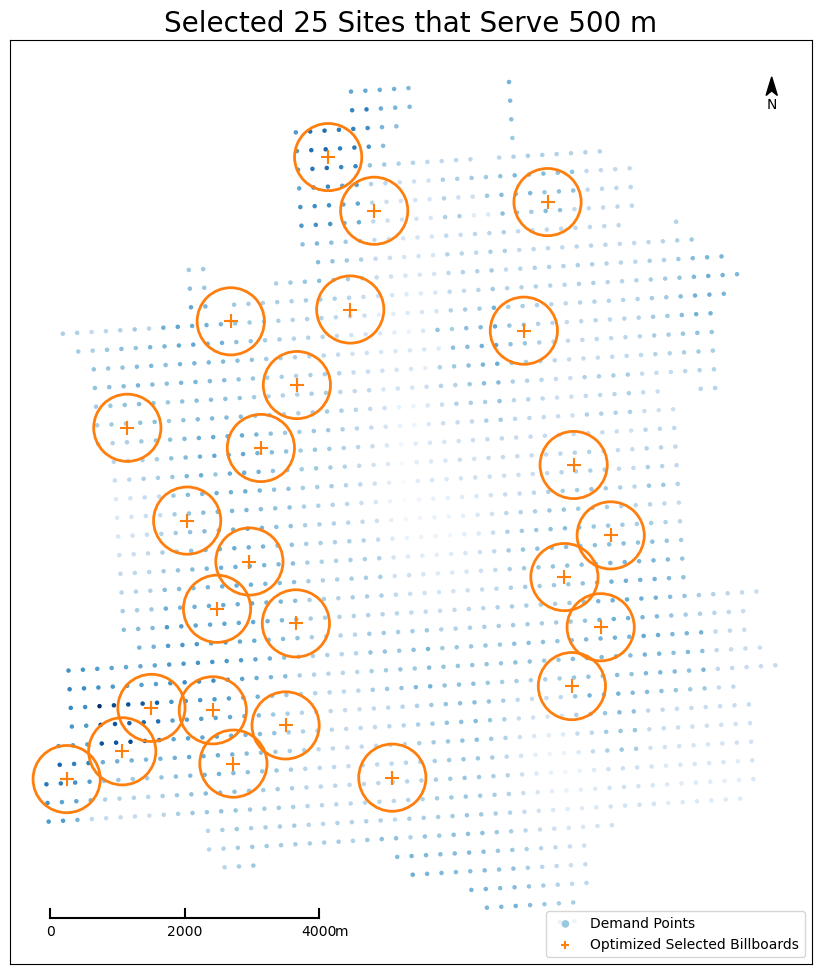

In [19]:
plot_result(ls,opt_sites,500)